<a href="https://colab.research.google.com/github/SimreAniri/Neural-Networks/blob/master/PyTorch_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [2]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True)
#         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [3]:
import pandas as pd

skeletons = pd.read_csv("skels.csv")

In [4]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [5]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3336,3337,3338,3339,3340,3341,3342,3343,3344,3345,3346,3347,3348,3349,3350,3351,3352,3353,3354,3355,3356,3357,3358,3359,3360,3361,3362,3363,3364,3365,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.526048,-0.277147,2.987706,-0.606184,-0.010056,3.010000,-0.681454,0.251614,3.020046,-0.708330,0.386629,3.087164,-0.704835,0.111742,2.856311,-0.515683,-0.024701,2.727949,-0.353615,-0.123308,2.706112,-0.327895,-0.141611,2.749221,-0.511823,0.157910,3.311851,-0.543163,-0.013495,3.108863,-0.496480,-0.181723,2.912678,-0.424105,-0.341968,2.685757,-0.559787,-0.277896,2.867135,-0.187794,...,-0.570154,-0.290760,2.955790,-0.255583,-0.187767,2.804032,-0.094777,-0.625936,2.721997,0.002962,-0.660430,2.645224,-0.491591,-0.281821,2.985380,-0.109749,-0.353734,2.758277,-0.016498,-0.707223,3.037502,0.080172,-0.741614,2.960732,-0.713666,0.178025,2.969061,-0.599133,0.702776,2.722800,-0.619659,0.647852,2.708625,-0.598600,0.593635,2.707864,-0.601837,0.592191,2.697301,0
1,-0.325320,-0.560200,3.244968,-0.296753,-0.312155,3.234485,-0.267607,-0.066345,3.212031,-0.286594,0.049026,3.222926,-0.412259,-0.156479,3.294798,-0.467307,-0.373163,3.353605,-0.452381,-0.607216,3.276438,-0.459716,-0.668793,3.282482,-0.160399,-0.179870,3.150078,-0.136725,-0.403121,3.128864,-0.160573,-0.601392,3.074458,-0.177965,-0.641335,3.074898,-0.368195,-0.549674,3.236222,-0.341016,...,-0.257144,-0.549525,3.252231,-0.284481,-0.867219,3.254666,-0.260625,-1.214738,3.346629,-0.287114,-1.243873,3.252890,-0.167253,-0.557715,3.216227,-0.177271,-0.884009,3.205395,-0.126542,-1.207360,3.246551,-0.155615,-1.256368,3.249898,-0.198894,-0.136859,3.196666,-0.064467,-0.539597,3.214681,-0.066076,-0.459657,3.206000,-0.227804,-0.654428,3.002556,-0.231687,-0.655208,3.000000,1
2,-0.134503,0.387048,3.797468,-0.135835,0.648782,3.669347,-0.137341,0.904024,3.529603,-0.131990,1.040210,3.459599,-0.305457,0.803356,3.557507,-0.347566,0.584975,3.688359,-0.388565,0.400258,3.742037,-0.379674,0.323533,3.767783,0.034142,0.812697,3.575421,0.083355,0.608419,3.697207,0.079156,0.419270,3.766705,0.059876,0.361420,3.788075,-0.211784,0.380342,3.759820,-0.271761,...,-0.250673,0.606249,3.497178,-0.311035,0.334250,3.712313,-0.343928,0.063761,4.068970,-0.354147,-0.027281,3.967637,-0.095314,0.609818,3.490057,-0.045545,0.354838,3.724567,-0.035290,0.029367,4.036292,-0.048035,-0.061396,3.934838,-0.160851,1.087236,3.319579,-0.358098,0.506673,3.490695,-0.332011,0.576840,3.451273,0.011452,0.521624,3.528420,-0.011325,0.589017,3.480000,1
3,0.371560,-0.187321,2.853457,0.388124,0.118966,2.756247,0.402399,0.418116,2.643035,0.354668,0.559822,2.625852,0.286102,0.348658,2.812573,0.241775,0.077759,2.934890,0.153760,-0.150245,2.875890,0.157503,-0.176863,2.863508,0.485513,0.267053,2.568110,0.518208,0.020373,2.588219,0.423660,-0.210078,2.590119,0.397967,-0.293417,2.620825,0.321781,-0.177898,2.866281,0.343763,...,0.329269,-0.174708,2.878668,0.336804,-0.538840,3.011136,0.415498,-0.883922,3.156997,0.344501,-0.925589,3.085428,0.418745,-0.186306,2.767760,0.473212,-0.551371,2.765115,0.550901,-0.958713,2.980955,0.478178,-0.999143,2.910031,0.389971,0.338643,2.666431,0.089315,0.707141,2.796196,0.106246,0.619960,2.735462,0.352891,-0.375651,2.625237,0.465385,-0.316062,2.651301,2
4,-0.193082,-0.178566,2.814345,-0.196894,0.114788,2.849780,-0.198289,0.400548,2.872416,-0.178771,0.542473,2.863049,-0.360317,0.275860,2.827222,-0.401500,0.038034,2.808956,-0.396649,-0.183429,2.708269,-0.390095,-0.255567,2.687460,-0.017156,0.265163,2.868467,0.011366,0.025235,2.858697,0.022230,-0.202932,2.776967,0.016230,-0.287072,2.753526,-0.258041,-0.174188,2.773036,-0.297204,...,-0.333521,-0.585503,3.089381,-0.355346,-0.564656,2.722364,-0.329321,-0.946284,2.762316,-0.323542,-0.986492,2.630332,-0.160405,-0.595503,3.097269,-0.071415,-0.572318,2.738775,-0.107231,-0.941284,2.766737,-0.103634,-0.981497,2.634580,-0.215003,-0.162058,3.060165,-0.551289,-0.465856,2.999218,

In [6]:
import torchvision
from torchvision import datasets, transforms

In [7]:
from torch.utils.data import DataLoader, Dataset

In [41]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
      #transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5, ])])
        self.data = pd.read_csv(file_path)
        self.transform = transform


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75)
        label = self.data.iloc[idx,-1]
        
        if self.transform != None:
            item = self.transform(item)

        return (item, label) 

In [60]:
dataset = Skeleton_Dataset(file_path = "skels.csv", transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5, ])]))

In [61]:
skel, lab = dataset.__getitem__(41)

In [62]:
type(skel)

torch.Tensor

In [63]:
LABELS[lab]

'sitting down'

In [64]:
skel.shape

torch.Size([1, 45, 75])

In [65]:
skels_for_draw = skel.reshape(-1,25,3)

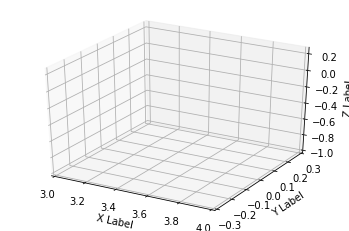

In [66]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib inline


bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((-0.3, 0.3))
    ax.set_zlim((-1.0, 0.25))
    ax.set_xlim((3.0, 4.0))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

#     plt.savefig('pics_1/test_' +str(i)+'.png', bbox_inches='tight')
#     plt.clf()

In [66]:
len(dataset)

636

In [17]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [424,212])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle=True)

In [18]:
n_hidden = 128
n_joints = 25*3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints,n_hidden,n_categories,n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [19]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [20]:
sket_tensor = torch.from_numpy(skel).unsqueeze(0).float()

In [21]:
sket_tensor.size()

torch.Size([1, 45, 75])

In [22]:
output = rnn(sket_tensor.to(device))

In [23]:
output.topk(5)

torch.return_types.topk(values=tensor([[ 0.0463,  0.0360,  0.0020, -0.0335, -0.1731]], device='cuda:0',
       grad_fn=<TopkBackward>), indices=tensor([[1, 2, 3, 0, 4]], device='cuda:0'))

In [24]:
from torch import optim
import time
import math

criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(800):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].to(device)
    
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            #####сделать более аккуратный вывод для каждой эпохии
            ######сделать обновление графика loss по ходу обучению  
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0
    

epoch : 0 iter : 0 (0m 0s) 1.5983  / hand waving ✗ (sitting down)
epoch : 18 iter : 14 (0m 16s) 1.6169  / hand waving ✗ (cheer up)
epoch : 37 iter : 1 (0m 32s) 1.5079  / sitting down ✓
epoch : 55 iter : 15 (0m 48s) 1.4450  / cheer up ✓
epoch : 74 iter : 2 (1m 5s) 0.9112  / sitting down ✓
epoch : 92 iter : 16 (1m 21s) 0.7679  / sitting down ✗ (clapping)
epoch : 111 iter : 3 (1m 37s) 0.9036  / hand waving ✓
epoch : 129 iter : 17 (1m 53s) 0.5258  / cheer up ✓
epoch : 148 iter : 4 (2m 10s) 0.5272  / sitting down ✓
epoch : 166 iter : 18 (2m 26s) 0.5977  / jump up ✓
epoch : 185 iter : 5 (2m 42s) 0.5688  / clapping ✓
epoch : 203 iter : 19 (2m 58s) 0.5355  / hand waving ✓
epoch : 222 iter : 6 (3m 14s) 0.2082  / sitting down ✓
epoch : 240 iter : 20 (3m 31s) 0.1045  / sitting down ✓
epoch : 259 iter : 7 (3m 47s) 0.2712  / cheer up ✓
epoch : 277 iter : 21 (4m 4s) 0.5269  / cheer up ✓
epoch : 296 iter : 8 (4m 20s) 0.1637  / clapping ✓
epoch : 314 iter : 22 (4m 36s) 0.1016  / clapping ✓
epoch : 333

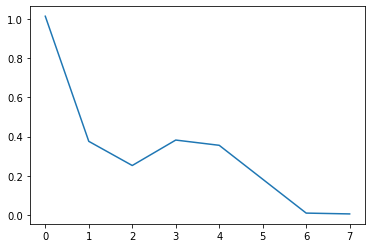

In [27]:
%matplotlib inline
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [26]:
total = 0
right = 0
counter = 0
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)   
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   78.57142857142857
